Fold 1 - R²: 0.5318709173672465, RMSE: 0.667859163792701
Fold 2 - R²: 0.4505181891143327, RMSE: 0.7129967484209117
Fold 3 - R²: 0.6745334084142292, RMSE: 0.601173416668904
Fold 4 - R²: 0.5398516864818903, RMSE: 0.7126016887571489
Fold 5 - R²: 0.5004607324040992, RMSE: 0.6598073157068808
RDKit 5-Fold Cross-Validation Mean R² score: 0.5394469867563596
RDKit 5-Fold Cross-Validation Mean RMSE: 0.6708876666693093


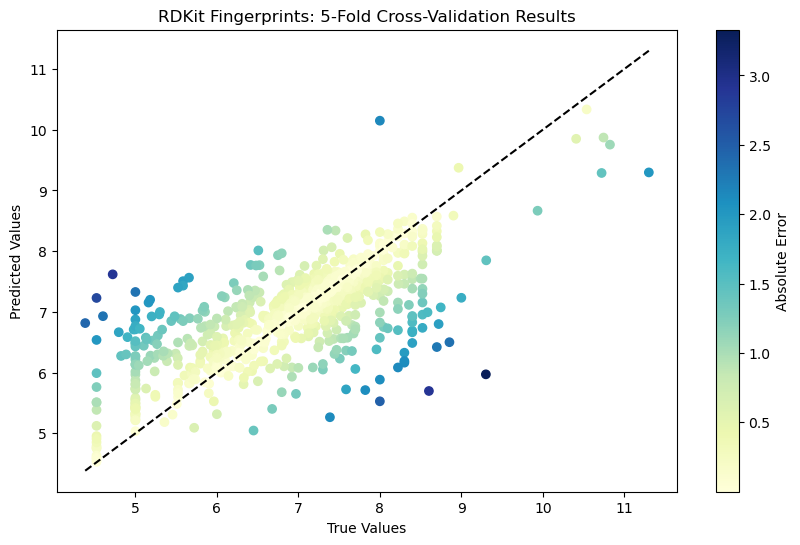

In [1]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import pickle

# 读取CSV文件
df = pd.read_csv('/home/vesper/文档/lab/CDK9/dataset/cleaned_CDK9.csv')

# 生成RDKit指纹
def generate_rdkit_fingerprints(mols):
    fps = [AllChem.RDKFingerprint(mol) for mol in mols if mol is not None]
    return fps

# 创建分子列表并进行检查
mols = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mols.append(mol)
    else:
        print(f"Invalid SMILES string: {smiles}")

# 生成指纹
fingerprints = generate_rdkit_fingerprints(mols)

# 将指纹转换为NumPy数组
fingerprint_arrays = []
for fp in fingerprints:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    fingerprint_arrays.append(arr)

X = np.array(fingerprint_arrays)
y = df['pIC50'].values[:len(X)]  # 确保标签和指纹数量一致

# 定义五倍交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 训练和评估模型
model = RandomForestRegressor(random_state=42)

all_test_predictions = np.zeros(len(y))
all_test_true_values = np.zeros(len(y))

r2_scores = []
rmse_scores = []

for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model.fit(X_train, y_train)
    
    test_predictions = model.predict(X_test)
    
    all_test_predictions[test_index] = test_predictions
    all_test_true_values[test_index] = y_test
    
    r2 = r2_score(y_test, test_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    
    print(f"Fold {fold_index + 1} - R²: {r2}, RMSE: {rmse}")

# 计算平均R²和RMSE
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)

# 打印平均结果
print(f"RDKit 5-Fold Cross-Validation Mean R² score: {mean_r2}")
print(f"RDKit 5-Fold Cross-Validation Mean RMSE: {mean_rmse}")

# 绘图函数
def plot_results(true_values, predicted_values, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(true_values, predicted_values, c=np.abs(true_values - predicted_values), cmap="YlGnBu", edgecolor=None)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], '--k')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Absolute Error')
    plt.show()

# 绘制五倍交叉验证的结果
plot_results(all_test_true_values, all_test_predictions, 'RDKit Fingerprints: 5-Fold Cross-Validation Results')

# 保存最终模型
model.fit(X, y)
with open('rdkit_random_forest_model_cv.pkl', 'wb') as f:
    pickle.dump(model, f)

Fold 1 - R²: 0.6114290405235452, RMSE: 0.6084673061721495
Fold 2 - R²: 0.44762378295279726, RMSE: 0.714872144136684
Fold 3 - R²: 0.6505672388236488, RMSE: 0.6229143995237046
Fold 4 - R²: 0.4763140380388392, RMSE: 0.7602096812671931
Fold 5 - R²: 0.3734809078962479, RMSE: 0.7389234769626474
AtomPair 5-Fold Cross-Validation Mean R² score: 0.5118830016470157
AtomPair 5-Fold Cross-Validation Mean RMSE: 0.6890774016124757


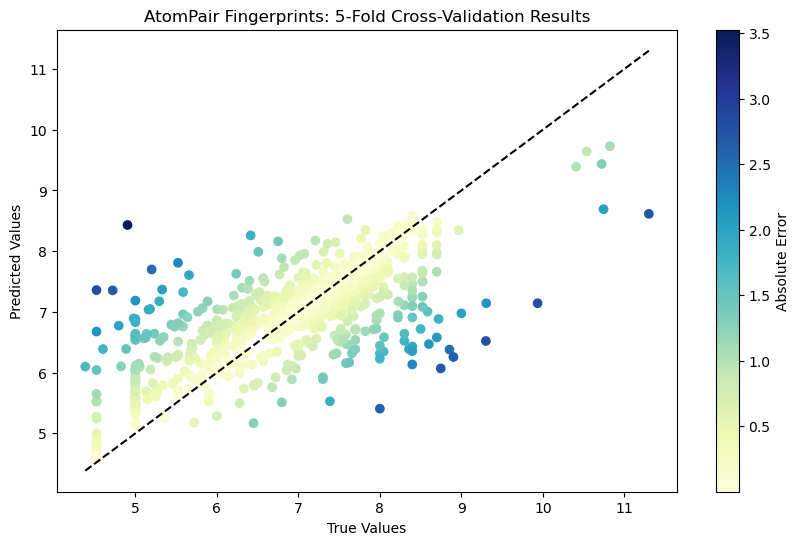

In [2]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pickle
from scipy import sparse
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('/home/vesper/文档/lab/CDK9/dataset/cleaned_CDK9.csv')

# 生成原子对指纹
def generate_fpgen_fingerprints(mols):
    fps = [AllChem.GetHashedAtomPairFingerprint(mol) for mol in mols if mol is not None]
    return fps

# 生成分子列表并进行检查
mols = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mols.append(mol)
    else:
        print(f"Invalid SMILES string: {smiles}")

# 生成指纹
fingerprints_fpgen = generate_fpgen_fingerprints(mols)

# 检查指纹生成是否成功
if not fingerprints_fpgen:
    raise ValueError("No valid fingerprints generated. Please check the SMILES strings.")

# 将指纹转换为稀疏矩阵
rows = []
cols = []
data = []
for i, fp in enumerate(fingerprints_fpgen):
    indices = list(fp.GetNonzeroElements().keys())
    values = list(fp.GetNonzeroElements().values())
    rows.extend([i] * len(indices))
    cols.extend(indices)
    data.extend(values)

X_sparse = sparse.coo_matrix((data, (rows, cols))).tocsr()  # 转换为csr_matrix
y = df['pIC50'].values[:X_sparse.shape[0]] 

# 检查数据维度是否匹配
if X_sparse.shape[0] != len(y):
    raise ValueError("Mismatch between number of fingerprints and target values.")

# 定义五倍交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储所有折的预测结果
all_test_predictions = np.zeros(len(y))
all_test_true_values = np.zeros(len(y))

r2_scores = []
rmse_scores = []

for fold_index, (train_index, test_index) in enumerate(kf.split(X_sparse)):
    X_train, X_test = X_sparse[train_index], X_sparse[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    test_predictions = model.predict(X_test)
    
    all_test_predictions[test_index] = test_predictions
    all_test_true_values[test_index] = y_test
    
    r2 = r2_score(y_test, test_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    
    print(f"Fold {fold_index + 1} - R²: {r2}, RMSE: {rmse}")

# 计算平均R²和RMSE
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)

# 打印平均结果
print(f"AtomPair 5-Fold Cross-Validation Mean R² score: {mean_r2}")
print(f"AtomPair 5-Fold Cross-Validation Mean RMSE: {mean_rmse}")

# 绘图函数
def plot_results(true_values, predicted_values, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(true_values, predicted_values, c=np.abs(true_values - predicted_values), cmap="YlGnBu", edgecolor=None)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], '--k')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Absolute Error')
    plt.show()

# 绘制五倍交叉验证的结果
plot_results(all_test_true_values, all_test_predictions, 'AtomPair Fingerprints: 5-Fold Cross-Validation Results')

# 保存最终模型
model.fit(X_sparse, y)
with open('AtomPair_random_forest_model_plot.pkl', 'wb') as f:
    pickle.dump(model, f)




Fold 1 - R²: 0.5343256819308595, RMSE: 0.6661058099275472
Fold 2 - R²: 0.4512080194114234, RMSE: 0.7125490527788132
Fold 3 - R²: 0.6849093163812692, RMSE: 0.591513065038162
Fold 4 - R²: 0.5814724613312057, RMSE: 0.6796102957716423
Fold 5 - R²: 0.36060952635961163, RMSE: 0.7464752120735627
Morgan 5-Fold Cross-Validation Mean R² score: 0.5225050010828739
Morgan 5-Fold Cross-Validation Mean RMSE: 0.6792506871179456


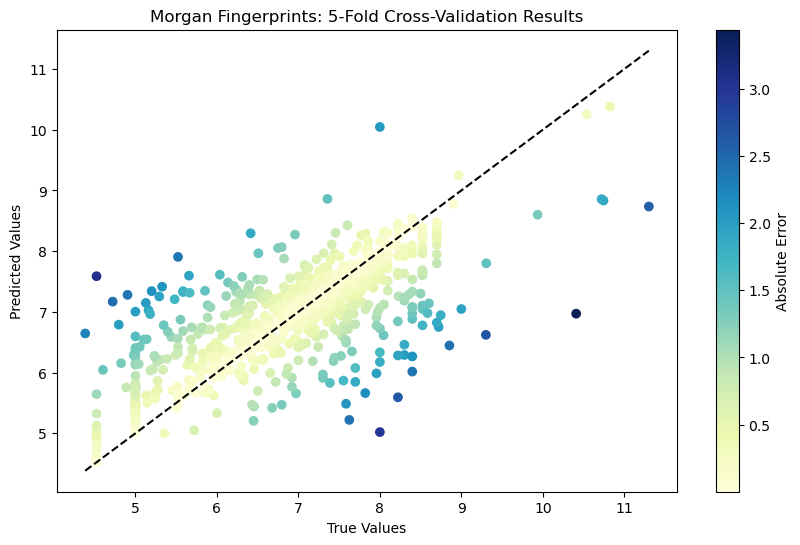

Loaded Model R² score on entire dataset: 0.9320649875230658
Loaded Model RMSE on entire dataset: 0.26068453477497505


In [3]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from scipy import sparse
import pickle
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('/home/vesper/文档/lab/CDK9/dataset/cleaned_CDK9.csv')

# 生成摩根指纹
def generate_mg_fingerprints(mols):
    fps = []
    for mol in mols:
        if mol is not None:
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
            arr = np.zeros((1,), dtype=np.int8)
            DataStructs.ConvertToNumpyArray(fp, arr)
            fps.append(arr)
    return fps

# 生成分子列表并进行检查
mols = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mols.append(mol)
    else:
        print(f"Invalid SMILES string: {smiles}")

# 生成指纹
fingerprints = generate_mg_fingerprints(mols)

# 将指纹转换为稀疏矩阵
X_sparse = sparse.csr_matrix(fingerprints)
y = df['pIC50'].values[:X_sparse.shape[0]]  # 确保标签和指纹数量一致

# 检查数据维度是否匹配
if X_sparse.shape[0] != len(y):
    raise ValueError("Mismatch between number of fingerprints and target values.")

# 定义五倍交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储所有折的预测结果
all_test_predictions = np.zeros(len(y))
all_test_true_values = np.zeros(len(y))

r2_scores = []
rmse_scores = []

for fold_index, (train_index, test_index) in enumerate(kf.split(X_sparse)):
    X_train, X_test = X_sparse[train_index], X_sparse[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    test_predictions = model.predict(X_test)
    
    all_test_predictions[test_index] = test_predictions
    all_test_true_values[test_index] = y_test
    
    r2 = r2_score(y_test, test_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    
    print(f"Fold {fold_index + 1} - R²: {r2}, RMSE: {rmse}")

# 计算平均R²和RMSE
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)

# 打印平均结果
print(f"Morgan 5-Fold Cross-Validation Mean R² score: {mean_r2}")
print(f"Morgan 5-Fold Cross-Validation Mean RMSE: {mean_rmse}")

# 绘图函数
def plot_results(true_values, predicted_values, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(true_values, predicted_values, c=np.abs(true_values - predicted_values), cmap="YlGnBu", edgecolor=None)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], '--k')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Absolute Error')
    plt.show()

# 绘制五倍交叉验证的结果
plot_results(all_test_true_values, all_test_predictions, 'Morgan Fingerprints: 5-Fold Cross-Validation Results')

# 保存最终模型
model.fit(X_sparse, y)
with open('Morgan_random_forest_model_plot.pkl', 'wb') as f:
    pickle.dump(model, f)

# 加载模型
with open('Morgan_random_forest_model_plot.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# 使用加载的模型进行预测（示例）
loaded_model_predictions = loaded_model.predict(X_sparse)
loaded_model_r2 = r2_score(y, loaded_model_predictions)
loaded_model_rmse = np.sqrt(mean_squared_error(y, loaded_model_predictions))

print(f"Loaded Model R² score on entire dataset: {loaded_model_r2}")
print(f"Loaded Model RMSE on entire dataset: {loaded_model_rmse}")


Fold 1 - R²: 0.5246026418351534, RMSE: 0.6730238584039997
Fold 2 - R²: 0.44188626692151056, RMSE: 0.7185752313113024
Fold 3 - R²: 0.6109161933013488, RMSE: 0.6573068200695596
Fold 4 - R²: 0.5056841367182752, RMSE: 0.7385845247244003
Fold 5 - R²: 0.31118315405260344, RMSE: 0.7747903270269411
MACCS 5-Fold Cross-Validation Mean R² score: 0.47885447856577823
MACCS 5-Fold Cross-Validation Mean RMSE: 0.7124561523072406


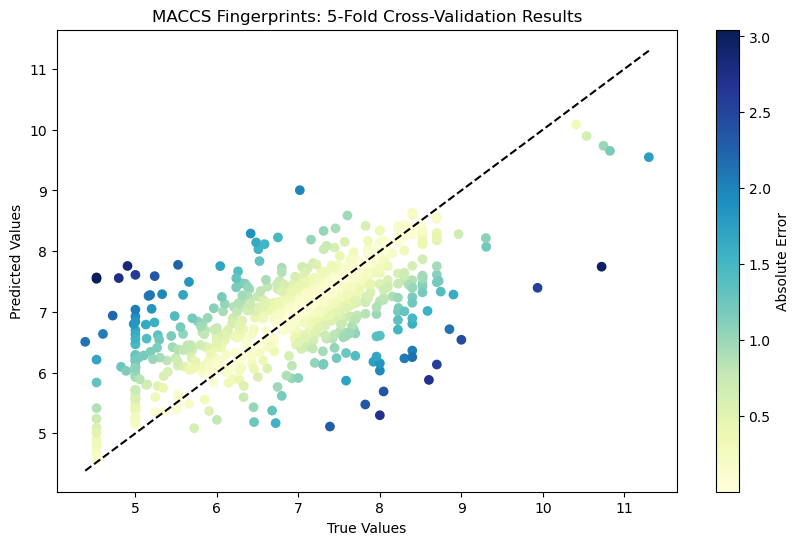

In [4]:
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, MACCSkeys
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
import pickle
import matplotlib.pyplot as plt

# 读取CSV文件
df = pd.read_csv('/home/vesper/文档/lab/CDK9/dataset/cleaned_CDK9.csv')

# 生成MACCS键指纹
def generate_MACCS_fingerprints(mols):
    fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
    return fps

# 生成分子列表并进行检查
mols = []
for smiles in df['smiles']:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        mols.append(mol)
    else:
        print(f"Invalid SMILES string: {smiles}")

# 生成指纹
fingerprints = generate_MACCS_fingerprints(mols)

# 检查指纹生成是否成功
if not fingerprints:
    raise ValueError("No valid fingerprints generated. Please check the SMILES strings.")

# 将指纹转换为NumPy数组
fingerprint_arrays = []
for fp in fingerprints:
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    fingerprint_arrays.append(arr)

X = np.array(fingerprint_arrays)
y = df['pIC50'].values[:len(X)]  # 确保标签和指纹数量一致

# 定义五倍交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 存储所有折的预测结果
all_test_predictions = np.zeros(len(y))
all_test_true_values = np.zeros(len(y))

r2_scores = []
rmse_scores = []

for fold_index, (train_index, test_index) in enumerate(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestRegressor(random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    
    test_predictions = model.predict(X_test)
    
    all_test_predictions[test_index] = test_predictions
    all_test_true_values[test_index] = y_test
    
    r2 = r2_score(y_test, test_predictions)
    rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
    
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    
    print(f"Fold {fold_index + 1} - R²: {r2}, RMSE: {rmse}")

# 计算平均R²和RMSE
mean_r2 = np.mean(r2_scores)
mean_rmse = np.mean(rmse_scores)

# 打印平均结果
print(f"MACCS 5-Fold Cross-Validation Mean R² score: {mean_r2}")
print(f"MACCS 5-Fold Cross-Validation Mean RMSE: {mean_rmse}")

# 绘图函数
def plot_results(true_values, predicted_values, title):
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(true_values, predicted_values, c=np.abs(true_values - predicted_values), cmap="YlGnBu", edgecolor=None)
    plt.plot([min(true_values), max(true_values)], [min(true_values), max(true_values)], '--k')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    colorbar = plt.colorbar(scatter)
    colorbar.set_label('Absolute Error')
    plt.show()

# 绘制五倍交叉验证的结果
plot_results(all_test_true_values, all_test_predictions, 'MACCS Fingerprints: 5-Fold Cross-Validation Results')

# 保存最终模型
model.fit(X, y)
with open('MACCS_random_forest_model_plot.pkl', 'wb') as f:
    pickle.dump(model, f)

